In [1]:
import os
import sys
import math
import copy
import shutil
import logging
from tqdm import tqdm
from contextlib import contextmanager
from copy import copy
from functools import partial
from operator import attrgetter
from operator import itemgetter
from collections.abc import Mapping
import fastcore.all as fc
from fastcore.test import test_close
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from fastprogress import progress_bar,master_bar

import torch
from torch import optim
from torch import nn, tensor
import torch.nn.functional as F
from torch.utils.data import default_collate
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler
from datasets import load_dataset, load_dataset_builder

/home/atcolab/mambaforge/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352616446/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

In [3]:
logging.disable(logging.WARNING)

In [4]:
x,y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

`decorator`

- we pass in a function 
- the function we passed in is called inside another function

In [5]:
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]
    
bs = 1024
tds = dsd.with_transform(transformi)

In [6]:
# dsd.with_transform?

In [7]:
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=2*bs, **kwargs))

In [8]:
class DataLoaders:
    def __init__(self, *dls):
        self.train, self.valid = dls[:2]
    
    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f))

In [9]:
one, two = tds['train'][0], tds['train'][1]

what `default_collate` does is separate the image and labels into respective groups

- so `{'image': imgs, label: tensor([9, 0])}`

In [10]:
ret = default_collate([one, two])

In [11]:
ret

{'image': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'label': tensor([9, 0])}

looks like `itemgetter` grabs the unique items

In [12]:
get = itemgetter(tds['train'].features)

In [13]:
tds['train'].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [14]:
get

operator.itemgetter({'image': Image(decode=True, id=None), 'label': ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)})

dataset is within dictionary

In [15]:
tds.values()

dict_values([Dataset({
    features: ['image', 'label'],
    num_rows: 60000
}), Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})])

what is the `*` used for?

- `*` is used to unpack a collection of elements into seperate positional args

In [16]:
def add(a,b,c):
    return a+b+c

nums = [1,2,3]
print(add(*nums))

6


In [17]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([1024, 784]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

In [18]:
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

what is `fc.store_attr`?

In [19]:
fc.store_attr?

Signature:
fc.store_attr(
    names=None,
    self=None,
    but='',
    cast=False,
    store_args=None,
    **attrs,
)
Docstring: Store params named in comma-separated `names` from calling context into attrs in `self`
File:      ~/mambaforge/lib/python3.9/site-packages/fastcore/basics.py
Type:      function


In [20]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD):
        fc.store_attr()
    
    def one_batch(self):
        self.xb, self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()
    
    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)
    
    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num, self.batch in enumerate(dl):
            self.one_batch()
        n = sum(self.ns)
        print(f'Epoch: {self.epoch+1} | isTraining: {self.model.training} | Loss: {sum(self.losses).item()/n} | Accuracy: {sum(self.accs).item()/n}')
    
    def fit(self, n_epochs):
        self.accs, self.losses, self.ns = [], [], []
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad():
                self.one_epoch(False)

In [21]:
m, nh = 28 * 28, 50
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [22]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

Epoch: 1 | isTraining: True | Loss: 1.1753045572916667 | Accuracy: 0.5986833333333333
Epoch: 1 | isTraining: False | Loss: 1.12032890625 | Accuracy: 0.6135285714285714


# Basic Callbacks Learner

In [ ]:
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [24]:
class Callback(): order = 0

In [25]:
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In [26]:
class CompletionCB(Callback):
    def before_fit(self, learn):
        self.count = 0
    def after_batch(self, learn):
        self.count += 1
    def after_fit(self, learn):
        print(f'Completed {self.count} batches')

In [27]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


Modify `CompletionCB` to also record total epochs

In [28]:
# class CompletionCB(Callback):
#     def before_fit(self, learn):
#         self.count = 0
#     def after_batch(self, learn):
#         self.count += 1
#     def before_epoch(self, learn):
#         self.epoch_count = 0
#     def after_epoch(self, learn):
#         self.epoch_count += 1
#     def after_fit(self, learn):
#         print(f'Completed {self.count} batches')    

class CompletionCB(Callback):
    def before_fit(self, learn):
        self.batch_count = 0
        self.epoch_count = 0
        
    def after_batch(self, learn):
        self.batch_count += 1
        
    def before_epoch(self, learn):
        pass
        
    def after_epoch(self, learn):
        self.epoch_count += 1
        
    def after_fit(self, learn):
        print(f'Completed {self.batch_count} batches over {self.epoch_count // 2} epochs')

In [29]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        fc.store_attr()
    
    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter, self.batch in tqdm(enumerate(self.dl), total=len(self.dl)):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass

    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

In [30]:
m, nh = 28*28, 50
def get_model(): return nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [31]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(2)

100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]

Completed 128 batches over 2 epochs


In [32]:
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()

In [33]:
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])

In [34]:
learn.fit(1)

  0%|                                                    | 0/59 [00:00<?, ?it/s]


# Metrics

In [35]:
class Metric:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.vals, self.ns = [], []
    
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    
    def calc(self, inps, targs): return inps

In [36]:
class Accuracy(Metric):
    def calc(self, inps, targs):
        return (inps==targs).float().mean()

In [37]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))

In [38]:
acc.value

tensor(0.45)

In [39]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

# Some Callbacks

In [40]:
from torcheval.metrics import MulticlassAccuracy, Mean

In [41]:
metric = MulticlassAccuracy()
metric.update(tensor([0,2,1,3]), tensor([0,1,2,3]))

In [42]:
metric.compute()

tensor(0.50)

In [43]:
metric.reset()
metric.compute()

tensor(nan)

In [44]:
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    return x.detach().cpu()

`*args` vs. `**kwargs`

- `*args` is used to pass a variable number of positional arguments, which are then packed into a `tuple`. In a function definitino, `*args` is used to define a parameter that will accept ANY NUMBER OF POSITIONAL ARGUMENTS PASSED TO THE FUNCTION.

- `**kwargs` is used to pass a variable number of keyword arguments which are then packed into a `dictionary`. In a function definition, `**kwargs` is used to define a parameter that will accept ANY NUMBER OF POSITONAL KEYWORD ARGUEMENTS PASSED TO THE FUNCTION.

In [45]:
def foo(*args, **kwargs):
    print('*args: ', args)
    print('**kwargs: ', kwargs)
    
foo(1,2,3,a=4,b=5)

*args:  (1, 2, 3)
**kwargs:  {'a': 4, 'b': 5}


what is `**metrics`?

- `**metrics` is the same as `**kwargs` 
- In Python, the syntax `**metrics` in a function or method parameters list means that the parameter is a variable-length keyword argument that accepts a dictionary of named arguments.
- `**metrics` appears as a catch-all parameter that accepts any number of keyword arguments

What is happening `for o in ms: metrics[type(o).__name__] = 0`

- The code is using `*ms` parameter to accept an arbitrary number of objects (as positional arguments), and then creating an entry in the `metrics` dictionary for each obj.
- The key in the `metrics` dictionary is set to the name of the classs of the object, obtained using the `type(o).__name__` expression, and the value is init. to `0`

- In other words, this code is assuming that each obj. passed to the `MetricsCB` callback is an instance of a class, and it is using the name of that class as a key in the `metrics` dictionary. 

what is happening here `x, y, *_ = to_cpu(learn.batch)`?

- The line `x, y, *_ = to_cpu(learn.batch)` is using extended iterable unpacking to assign the first two elements of the learn.batch tuple to the variables x and y, and the remaining elements (if any) to the variable `_`.

In [46]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: 
            metrics[type(o).__name__] = 0
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
    
    def _log(self, d): print(d)
    
    def before_fit(self, learn): learn.metrics = self
    
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]
    
    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)
    
    def after_batch(self, learn):
        x, y, *_ = to_cpu(learn.batch)
        for m in self.metrics.values():
            m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

- The `MetricsCB` callback allows you to track multiple metrics during training and evaluation, including the loss. It logs the metrics at the end of each epoch, and it resets the metrics at the beginning of each epoch. 

- The `_log` method of the `MetricsCB` instance can be overridden to customize the logging behvaior. By default, it prints a dictionary of the metrics and their values at the end of each epoch

In [47]:
metrics_cb = MetricsCB(accuracy=MulticlassAccuracy(), mean=Mean())
metrics_cb.metrics

{'accuracy': <torcheval.metrics.classification.accuracy.MulticlassAccuracy at 0x7fe6d0091160>,
 'mean': <torcheval.metrics.aggregation.mean.Mean at 0x7fe6d57d2d00>}

In [48]:
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    
    def before_batch(self, learn):
        learn.batch = to_device(learn.batch, device=self.device)

In [49]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

100%|███████████████████████████████████████████| 59/59 [00:12<00:00,  4.78it/s]


{'accuracy': '0.611', 'loss': '1.176', 'epoch': 0, 'train': 'train'}


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]

{'accuracy': '0.677', 'loss': '0.857', 'epoch': 0, 'train': 'eval'}


# Flexible Learner

In [50]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()
        
    @contextmanager
    def cb_ctx(self, nm):
        try: 
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')
    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter, self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        
        for cb in cbs: self.cbs.append(cb)
        
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs:
                self.cbs.remove(cb)
        
    def __getattr__(self, name):
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)
    
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

    @property
    def training(self):
        return self.model.training    

We don't have the following `('predict', 'get_loss', 'backward', 'step', 'zero_grad')` in our `Learner` class, however, we can use `Callback` to add these functionalities

In [51]:
#|export
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [52]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()
    
    @contextmanager
    def cb_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')
    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter, self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
                        
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        
        for cb in cbs: self.cbs.append(cb)
        
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs:
                self.cbs.remove(cb)
    
    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)
    
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

    @property
    def training(self): return self.model.training

In [55]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

In [56]:
model = get_model()

accuracy,loss,epoch,train
0.616,1.168,0,train
0.719,0.789,0,eval


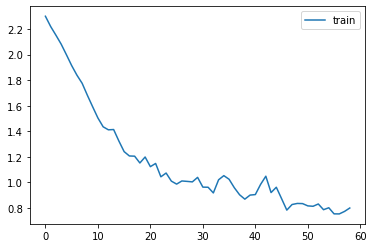

In [57]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

# Updated versions since the lesson

In [58]:
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

In [59]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()
    
    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()
        
    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter, self.batch in enumerate(self.dl): self._one_batch()
    
    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()
    
    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)
        
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)
    
    def __getattr__(self, name):
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)
    
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

    @property
    def training(self): return self.model.training

accuracy,loss,epoch,train
0.607,1.183,0,train
0.712,0.787,0,eval


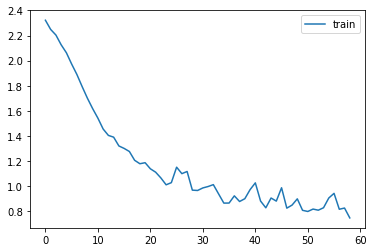

In [60]:
model = get_model()

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

# TrainLearner and MomentumLearner

In [61]:
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [62]:
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)
    
    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

accuracy,loss,epoch,train
0.662,0.942,0,train
0.796,0.589,0,eval


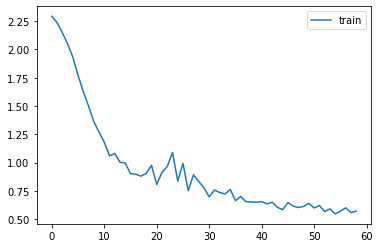

In [63]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

# LRFinderCB

In [64]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3):
        fc.store_attr()
    
    def before_fit(self, learn):
        self.lrs, self.losses = [], []
        self.min = math.inf
    
    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult

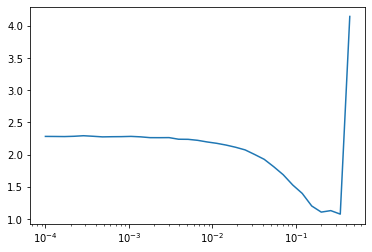

In [65]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

In [66]:
from torch.optim.lr_scheduler import ExponentialLR

In [67]:
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult):
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

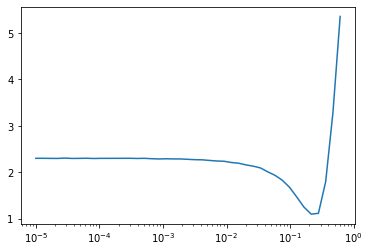

In [68]:
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCB())

In [69]:
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

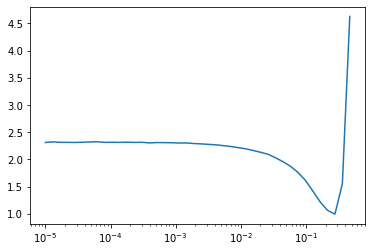

In [70]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find()